### *This file allows to plot gallop to trot transitions under a population analysis*

# **Useful packages and functions**

In [14]:
using Plots, LaTeXStrings, Random, Dierckx, DelimitedFiles
include("quad_STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("quad_STG_models.jl") # Loading of STG model
include("quad_STG_utils.jl") # Loading of some utils functions
include("quad_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("quad_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("quad_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [15]:
# Definition of simulation time (in ms)
const Tfinal = 50000
const dt = 0.0005
const tsim = 0 : dt : Tfinal
const dtplot = 0.2
const tt = 0 : dtplot : Tfinal
const dtratio = Int(dtplot/dt)
const Tdt = Int(Tfinal/dt)
const tt_index = 1 : dtratio : Tdt+1

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const Vsyn = -75. # Reversal potential of synaptic channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 1

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
default(fmt = :png);

# **Gallop to trot, population analysis**

# Plot population simulation

In [16]:
using Interpolations

In [17]:
tt_match = 0 : 0.1 : 30
g_all = zeros(8, 200)
phase_1_all = zeros(length(tt_match), 200)
phase_2_all = zeros(length(tt_match), 200)
phase_3_all = zeros(length(tt_match), 200)
phase_4_all = zeros(length(tt_match), 200)

for i = 1 : 200
    if i == 200
        i = 544
    end
    
    # Reading results
    phase1 = readdlm("./data/phase1_"*string(i)*".dat")
    phase2 = readdlm("./data/phase2_"*string(i)*".dat")
    phase3 = readdlm("./data/phase3_"*string(i)*".dat")
    phase4 = readdlm("./data/phase4_"*string(i)*".dat")
    t1 = readdlm("./data/t1_"*string(i)*".dat")
    t2 = readdlm("./data/t2_"*string(i)*".dat")
    t3 = readdlm("./data/t3_"*string(i)*".dat")
    t4 = readdlm("./data/t4_"*string(i)*".dat")
    g_i = readdlm("./data/g_"*string(i)*".dat")
    
    if i == 544
        i = 200
    end
    
    # Removing NaNs
    non_nan_indices1 = .!isnan.(vec(phase1))
    phase1_wout_nan = vec(phase1)[non_nan_indices1]
    t1_wout_nan = vec(t1)[non_nan_indices1]
    
    non_nan_indices2 = .!isnan.(vec(phase2))
    phase2_wout_nan = vec(phase2)[non_nan_indices2]
    t2_wout_nan = vec(t2)[non_nan_indices2]
    
    non_nan_indices3 = .!isnan.(vec(phase3))
    phase3_wout_nan = vec(phase3)[non_nan_indices3]
    t3_wout_nan = vec(t3)[non_nan_indices3]
    
    non_nan_indices4 = .!isnan.(vec(phase4))
    phase4_wout_nan = vec(phase4)[non_nan_indices4]
    t4_wout_nan = vec(t4)[non_nan_indices4]
    
    # Interpolating
    interp1 = linear_interpolation(t1_wout_nan./1e3 .- 15, phase1_wout_nan, extrapolation_bc=Line())
    interp2 = linear_interpolation(t2_wout_nan./1e3 .- 15, phase2_wout_nan, extrapolation_bc=Line())
    interp3 = linear_interpolation(t3_wout_nan./1e3 .- 15, phase3_wout_nan, extrapolation_bc=Line())
    interp4 = linear_interpolation(t4_wout_nan./1e3 .- 15, phase4_wout_nan, extrapolation_bc=Line())
    
    # Storing
    phase_1_all[:, i] = interp1(tt_match)
    phase_2_all[:, i] = interp2(tt_match)
    phase_3_all[:, i] = interp3(tt_match)
    phase_4_all[:, i] = interp4(tt_match)
    g_all[:, i] = g_i
end

In [18]:
span_phase1 = zeros(length(tt_match))
span_phase2 = zeros(length(tt_match))
span_phase3 = zeros(length(tt_match))
span_phase4 = zeros(length(tt_match))

mean_phase1 = zeros(length(tt_match))
mean_phase2 = zeros(length(tt_match))
mean_phase3 = zeros(length(tt_match))
mean_phase4 = zeros(length(tt_match))

for i = 1 : length(tt_match)
    mean_phase1[i] = mean(phase_1_all[i, :])
    mean_phase2[i] = mean(phase_2_all[i, :])
    mean_phase3[i] = mean(phase_3_all[i, :])
    mean_phase4[i] = mean(phase_4_all[i, :])
    
    span_phase1[i] = std(phase_1_all[i, :])
    span_phase2[i] = std(phase_2_all[i, :])
    span_phase3[i] = std(phase_3_all[i, :])
    span_phase4[i] = std(phase_4_all[i, :])
end

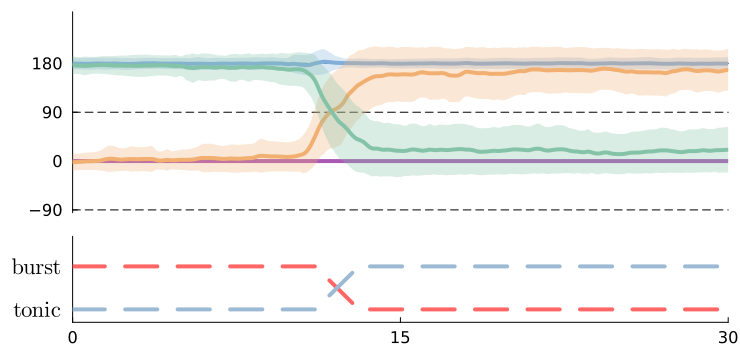

In [19]:
gr(guidefontsize=18, legendfontsize=12, margin=0Plots.mm, grid=false)

p = hline([180], color=:black, linestyle=:dash, tickfontsize=11, xticks=false)
hline!([90], color=:black, linestyle=:dash)
hline!([-90], color=:black, linestyle=:dash)
plot!(tt_match, mean_phase1, label="LH", color=myPurple, legend=false, linewidth=4,
         ribbon=span_phase1, fillalpha=.3)
plot!(tt_match, mean_phase2, label="LF", color=myBlue, legend=false, linewidth=4,
         ribbon=span_phase2, fillalpha=.3)
plot!(tt_match, mean_phase3, label="RH", color=myOrange, legend=false, linewidth=4,
         ribbon=span_phase3./1.5, fillalpha=.3)
plot!(tt_match, mean_phase4, label="RF", color=myGreen, legend=false, linewidth=4,
         ribbon=span_phase4./1.5, fillalpha=.3)
xlims!((0, 30))
ylims!((-95, 275))
yticks!([-90, 0, 90, 180])
xaxis!(false)


myNmodRed = RGBA(255/255, 102/255, 102/255, 1)
myNmodBlue = RGBA(156/255, 186/255, 211/255, 1)
p2 = plot(ylims=(0, 2), tickfontsize=11)
ttt = [0, 11, 11.1, 13.1, 30]
thresh = 12
gallop(t) = 1.3*(t<=thresh) + 0.3 * (t>thresh)
trot(t) = 0.3*(t<=thresh) + 1.3 * (t>thresh)
plot!(ttt, gallop.(ttt), color=myNmodRed, linewidth=4, linestyle=:dash, legend=false)
plot!(ttt, trot.(ttt), color=myNmodBlue, linewidth=4, linestyle=:dash, ytickfontsize=15)
yticks!([0.3, 1.3], [L"\mathrm{tonic}", L"\mathrm{burst}"])
xticks!(([0, 15, 30], ["0", "15", "30"]))
xlims!((0, 30))

CC = plot(p, p2, layout = grid(2, 1, heights=[0.7, 0.3]), margin=1Plots.mm, size=(740,350))
# savefig(CC, "phase_transition_pop.pdf")

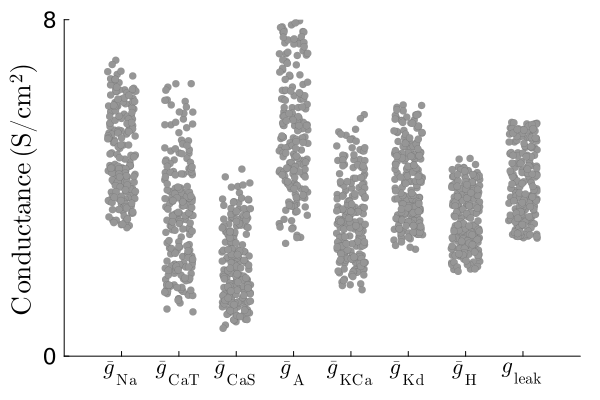

In [20]:
myGray = RGBA(150/255, 150/255, 150/255, 1)
# Defining a matrix containing all conductances
g_all_bar = zeros(200, 8)
scaling =  [1, 700, 150, 15, 30, 25, 9000, 400000]
for i = 1 : 8
    g_all_bar[:, i] = g_all[i, :] .* scaling[i] / 1e3
end

p4 = scatter(rand(200) .* 0.5 .+ 0.75, g_all_bar[:, 1], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 1.75, g_all_bar[:, 2], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 2.75, g_all_bar[:, 3], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 3.75, g_all_bar[:, 4], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 4.75, g_all_bar[:, 5], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 5.75, g_all_bar[:, 6], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 6.75, g_all_bar[:, 7], label="", color=myGray, markerstrokewidth=0.)
scatter!(rand(200) .* 0.5 .+ 7.75, g_all_bar[:, 8], label="", grid=false, yguidefontsize=18, 
         color=myGray, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, markerstrokewidth=0.,
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, 
         ylabel=L"\mathrm{Conductance}\,\,\mathrm{(S/cm^2)}",
         xticks=(1:8, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
         L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
         L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]))

xlims!((0., 9.))
ylims!((0, 8))

display(p4)
# savefig(p4, "gbar.pdf")